# VALIDATION STRATEGY - RETAIL DEMAND PREDICTION

* Now, that we have seen Tree based models were giving better results. So, we will use RandomForest Regressor Model in this notebook and we will define our validation strategy to make sure that the model we build is robust.

We need to find out what would be the

* right number of validation sets such that we can get reliable estimates of RMSLE
* right size of the training data to get a robust model

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm

from datetime import timedelta

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('updated_train_data.csv')

In [3]:
train_df.dtypes

WEEK_END_DATE     object
STORE_NUM          int64
UPC                int64
BASE_PRICE       float64
FEATURE            int64
DISPLAY            int64
UNITS              int64
MONTH              int64
dtype: object

In [4]:
train_df.head(2)

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS,MONTH
0,2009-01-14,367,1111009477,1.57,0,0,13,1
1,2009-01-14,367,1111009497,1.39,0,0,20,1


In [5]:
train_df['WEEK_END_DATE'] = pd.to_datetime(train_df['WEEK_END_DATE'])

In [6]:
train_df['WEEK_END_DATE'].min(), train_df['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

In [7]:
train_df['WEEK_END_DATE'].nunique()

142

In [8]:
weeks = train_df['WEEK_END_DATE'].unique()

In [9]:
product_df = pd.read_csv('updated_product_data.csv')
store_df = pd.read_csv('updated_store_data.csv')

In [10]:
mega_df = train_df.merge(product_df, how = 'left', on = 'UPC')
mega_df = mega_df.merge(store_df, how = 'left', left_on = 'STORE_NUM', right_on = 'STORE_ID')
mega_df = mega_df.drop(columns = 'STORE_ID', axis = 1)

In [11]:
mega_df.iloc[0]

WEEK_END_DATE                2009-01-14 00:00:00
STORE_NUM                                    367
UPC                                   1111009477
BASE_PRICE                                  1.57
FEATURE                                        0
DISPLAY                                        0
UNITS                                         13
MONTH                                          1
MANUFACTURER_1                                 1
MANUFACTURER_2                                 0
MANUFACTURER_3                                 0
MANUFACTURER_4                                 0
MANUFACTURER_5                                 0
MANUFACTURER_6                                 0
MANUFACTURER_7                                 0
MANUFACTURER_8                                 0
MANUFACTURER_9                                 0
CATEGORY_1                                     1
CATEGORY_2                                     0
CATEGORY_3                                     0
CATEGORY_4          

---
### VALIDATION STRATEGY:
---
**For a single iteration, we define a training period on which we will train the model and then we will have one week gap and validate on the next week and again one week gap and test on the next week**

As, the suppliers need 1 week head start for supplying the requested goods to warehouses so we will predict not for the next week but next to the next week as that is the week for which our forecasts would be used in practical scenario.

***Now, we need to find out what would be the optimal `number of validation sets` and optimal `number of months` on which we should validate the data.***





- Define a function `validation_df` that will take the parameters array of `week`, `no_of_months`, `no_of_validation` and returns a dataframe that contains the imformation like:

 * `week` unique week_end_dates array
 * `no_of_months` training data duration that needs to be considered
 * `no_of_validation` number of validation sets that needs to be created with training period as specified
 *  `train_start`  Data split train set start week
 *  `train_end`  Data split train set end week
 *  `no_days_train`  Number of days we have in the particular validation set
 *  `validation_week`  Data split validation week
 *  `test_week`  Data split test week
 *  `train_shape` Datapoints available in the train split 
 *  `validation_shape` Datapoints available in the validation week
 *  `test_shape` Datapoints available in the test week

In [12]:
# function to create validation data_frame
def validation_df(data, weeks, no_of_months, no_of_validations):
    
    model_set = []
    set_n = 1
    for w in range(len(weeks)-1, 0, -1):
        x_data = {}
        
        x_data['set_no'] = 'set' + str(set_n)
        x_data['train_start'] = weeks[w-3-4*no_of_months]
        x_data['train_end'] = weeks[w-4]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['valid_week'] = weeks[w-2]
        x_data['test_week'] = weeks[w]
        
        set_n += 1
        model_set.append(x_data)
        if (len(model_set)) == no_of_validations:
            break            
    
    
    datapoints = []
    
    for s in model_set:
        x = {}
        train_set = data[(data['WEEK_END_DATE'] >= s['train_start']) & (data['WEEK_END_DATE'] <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['valid_shape'] = data[data['WEEK_END_DATE'] == s['valid_week']].shape[0]
        x['test_shape'] = data[data['WEEK_END_DATE'] == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)
        
    
    df = pd.DataFrame(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df

In [13]:
# validation sets for training size = 3 months and number of validation sets = 3
validation_df(mega_df, weeks, no_of_months= 3, no_of_validations= 3)

,train_shape,valid_shape,test_shape,set_no,train_start,train_end,no_days_train,valid_week,test_week
0,19647,1640,1642,set1,2011-06-15,2011-08-31,84 days,2011-09-14,2011-09-28
1,19657,1632,1638,set2,2011-06-08,2011-08-24,84 days,2011-09-07,2011-09-21
2,19654,1629,1640,set3,2011-06-01,2011-08-17,84 days,2011-08-31,2011-09-14


In [14]:
# validation sets for training size = 6 months and number of validation sets = 4
validation_df(mega_df, weeks, no_of_months= 6, no_of_validations=4)

,train_shape,valid_shape,test_shape,set_no,train_start,train_end,no_days_train,valid_week,test_week
0,39294,1640,1642,set1,2011-03-23,2011-08-31,168 days,2011-09-14,2011-09-28
1,39308,1632,1638,set2,2011-03-16,2011-08-24,168 days,2011-09-07,2011-09-21
2,39308,1629,1640,set3,2011-03-09,2011-08-17,168 days,2011-08-31,2011-09-14
3,39308,1640,1632,set4,2011-03-02,2011-08-10,168 days,2011-08-24,2011-09-07


Now, we will calculate **EVALUATION METRIC - RMSLE** for each of the combination of traininig period size from 1 month to 12 months and number of validation sets from 1 to 5. We will use RandomForestRegressor Model

In [15]:
# function to calculate Root-Mean-Squared-Log-Error
def get_rmsle(true, predicted):
    return np.sqrt(msle(true, predicted))


# Function to train the model
# it will calculate RMLSE on train & validation set
def my_model(train_d, valid_d):
    
    train_x = train_d.drop(columns = ['WEEK_END_DATE', 'UPC', 'STORE_NUM', 'UNITS'])
    train_y = train_d['UNITS']
    
    valid_x = train_d.drop(columns = ['WEEK_END_DATE', 'UPC', 'STORE_NUM', 'UNITS'])
    valid_y = train_d['UNITS']
    
    RFR = RandomForestRegressor(max_depth = 20, random_state =0)
    RFR.fit(train_x, train_y)
    
    valid_predict = RFR.predict(valid_x).clip(min=0)
    
    return get_rmsle(valid_y, valid_predict)
    
    
# Function will extract train & validation sets using validation dataframe
# The defined model will train on each of the set using train_model function. 
# And it'll return the average RMSLE and standard deviation on validation
def train_model(df, no_of_month):
    
    model_results = []
    for r in range(df.shape[0]):
        row = df.iloc[r]
        train_set = train_df[(train_df['WEEK_END_DATE'] >= row['train_start']) & (train_df['WEEK_END_DATE'] <= row['train_end'])]
        valid_set = train_df[train_df['WEEK_END_DATE'] == row['valid_week']]
        train_set['month'] = no_of_month
        valid_set['month'] = no_of_month
        model_results.append(my_model(train_set, valid_set))
        
    return np.mean(model_results), np.std(model_results)

Now, we define a function **get_matrix** that will take parameter **max_months:** the number of months of training period and **max_cv:** the number of validation sets.

It will return mean rmsle and standard deviation of the rmsle calculated over the different combinations of the months and validation sets.

In [16]:
def get_matrix(max_months =1, max_cv=1):
    
    final_results_mean = []
    final_results_std = []
    
    for i in tqdm(range(1, max_months+1, 1)):
        for j in range(1, max_cv+1, 1):
            
            x = {}
            y = {}
            
            x['no_of_months'] = i
            x['validation_sets'] = j
            y['no_of_months'] = i
            y['validation_sets'] = j
            
            x['results'], y['results'] = train_model(validation_df(mega_df, weeks, no_of_months = i, no_of_validations = j), i)
            final_results_mean.append(x)
            final_results_std.append(y)
            
    return pd.DataFrame(final_results_mean).pivot_table(index = 'no_of_months', columns = 'validation_sets', fill_value = 0), pd.DataFrame(final_results_std).pivot_table(index = 'no_of_months', columns = 'validation_sets', fill_value = 0)


In [17]:
final_mean, final_std = get_matrix(max_months=12,max_cv=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [12:11<00:00, 60.93s/it]


In [18]:
final_mean.columns = final_mean.columns.droplevel()

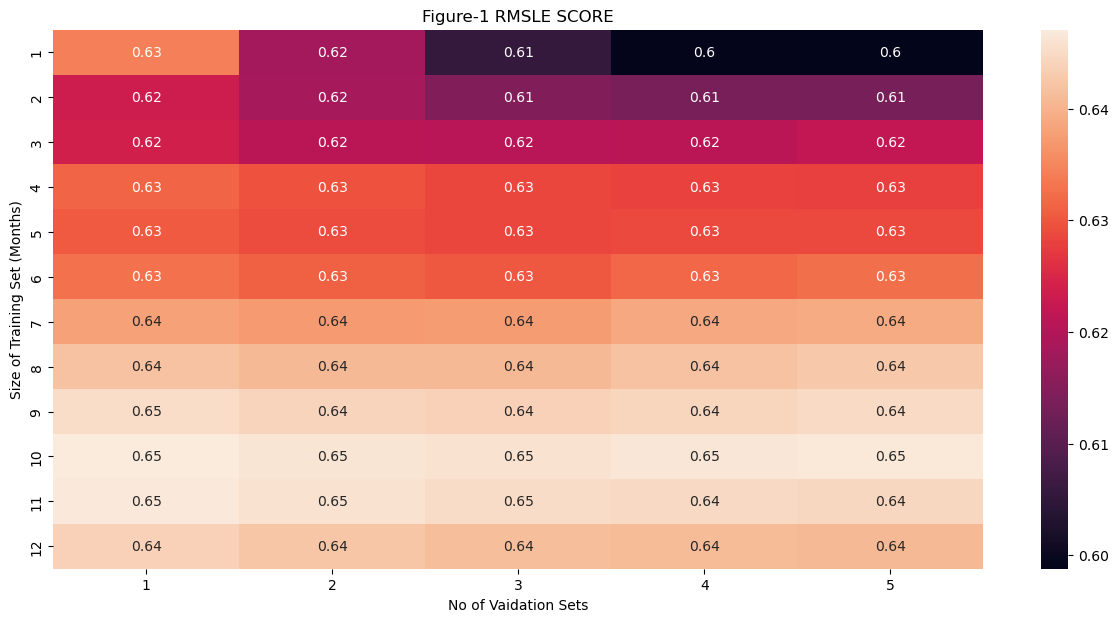

In [27]:
plt.figure(figsize = (15,7))
sns.heatmap(final_mean, annot = True)
plt.xlabel('No of Vaidation Sets')
plt.ylabel('Size of Training Set (Months)')
plt.title('Figure-1 RMSLE SCORE')
plt.show()

We can see that, as we increase the size of the training period, the value of RMSLE increases. **For 1 month** of train data we are getting the best score here and it keeps on increasing as we go further back. So, Let's calculate the results again by keeping the max training period to be 4 months and no of validation sets to be 15.

In [21]:
final_mean2, final_std2 = get_matrix(max_months=4,max_cv=15)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [23:47<00:00, 356.95s/it]


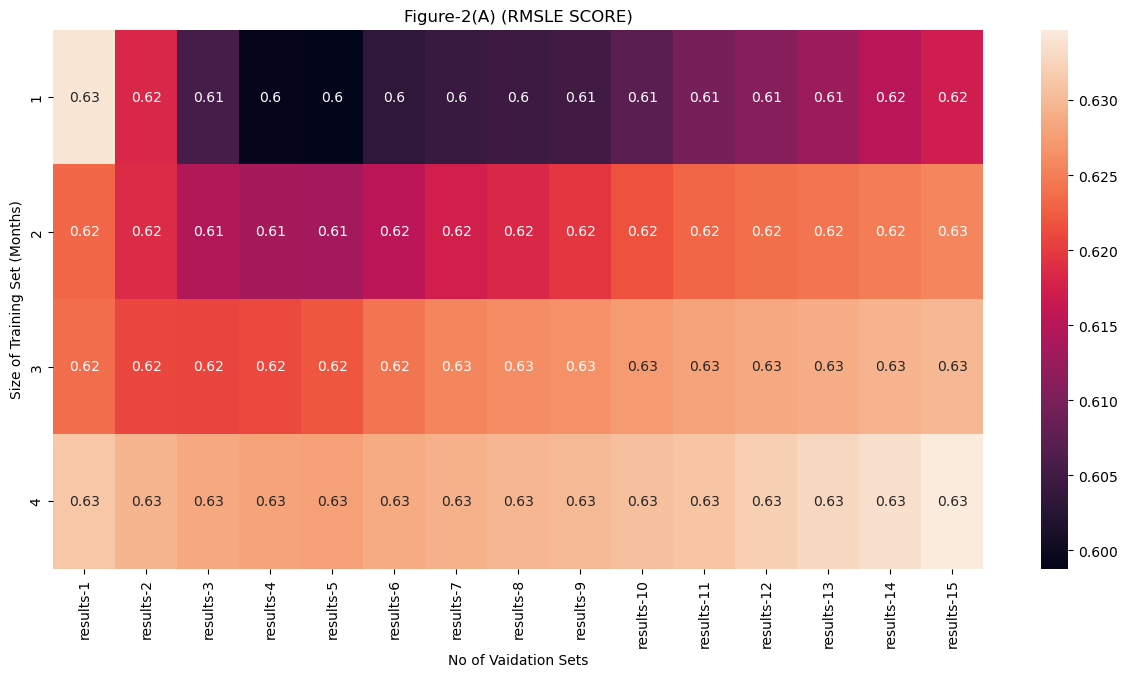

In [25]:
plt.figure(figsize = (15,7))
sns.heatmap(final_mean2, annot = True)
plt.xlabel('No of Vaidation Sets')
plt.ylabel('Size of Training Set (Months)')
plt.title('Figure-2(A) (RMSLE SCORE)')
plt.show()

Let's see which combination has the least deviation in the RMSLE.

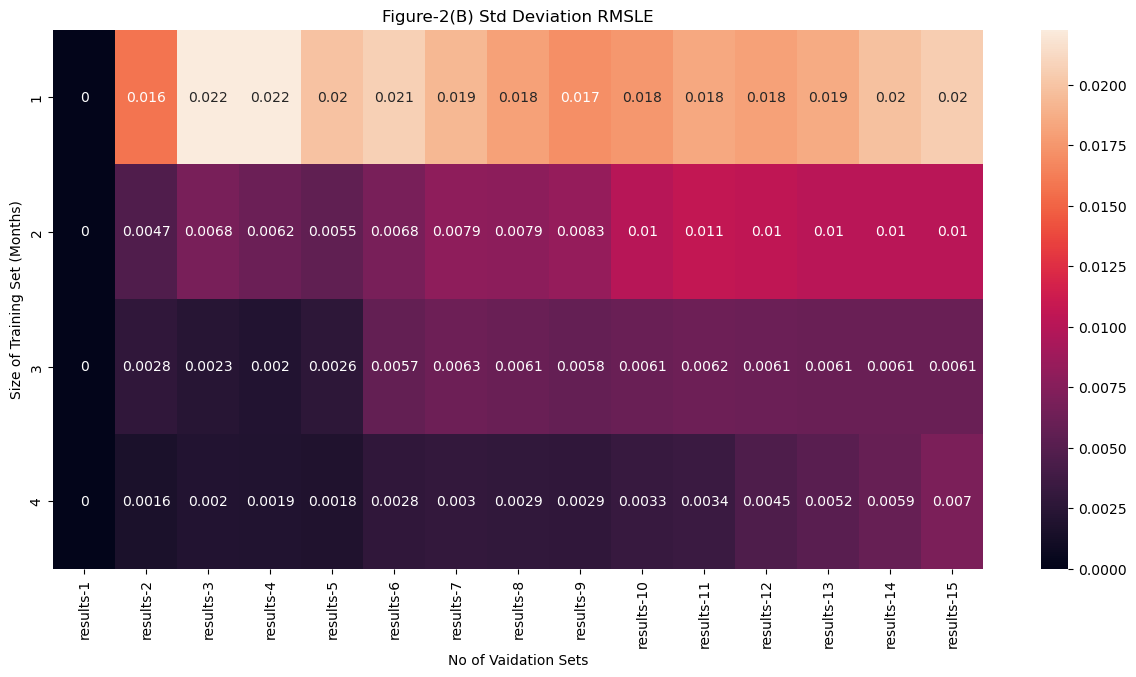

In [26]:
plt.figure(figsize = (15,7))
sns.heatmap(final_std2, annot = True)
plt.xlabel('No of Vaidation Sets')
plt.ylabel('Size of Training Set (Months)')
plt.title('Figure-2(B) Std Deviation RMSLE')
plt.show()

**CONCLUSION :**
* In Figure 1 found out that the best RMSLE **(0.60)** score we're getting for a training period of 1 Month.
* Figure 2(A) and 2(B) show that the lowest RMSLE score and the Lowest Deviation in RMSE Score is for The number of Validations set = 9.
* Final Result: Optimal values are **Training Period Size = 1 month** and **No of Validatons = 9**